<a href="https://colab.research.google.com/github/giriragav/Qiskit/blob/main/Quantum_Rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# qiskit
# qiskit-aer
# qiskit-ibm-runtime
# ipywidgets
# matplotlib
# numpy
# ipython
# pandas

# Enhanced imports for interactive visualizations and animations

!pip install qiskit  # Uncomment if Qiskit is not installed
!pip install qiskit-aer
!pip install qiskit-ibm-runtime
!pip install ipywidgets
!pip install matplotlib
!pip install numpy
!pip install pylatexenc

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
import ipywidgets as widgets
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator,QiskitRuntimeService
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import transpile

import qiskit
print(qiskit.__version__)
import time

# Configure matplotlib for better display
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 8
%matplotlib inline



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=f215b7f6d8af770c9b78e39b7297037f0aa3443fcd3e5ca1478cf548aa61d211
  Stored in dire

In [2]:

def create_and_visualize_gate(gate_name, circuit_func, shots=100, run=False):
	"""Helper function to visualize Bloch sphere before and after applying a gate side by side"""
	print(f"\n{'='*50}")
	print(f"QUANTUM GATE: {gate_name}")
	print(f"{'='*50}")

	# Create the quantum circuit
	qc = circuit_func()

	print("\nCircuit Diagram:")
	#print(qc.draw(output='text'))

	try:
		_, ax = plt.subplots(1, 1, figsize=(4, 2))
		qc.draw(output='mpl', ax=ax)
		plt.title(f"{gate_name} - Circuit Diagram")
		plt.tight_layout()
		plt.show()
	except Exception as e:
		print(f"Circuit diagram error: {e}")

	if qc.num_qubits <= 3:
		try:
			initial_state = Statevector.from_instruction(QuantumCircuit(qc.num_qubits))  # |0⟩ state

			qc_statevector = qc.copy()
			# try to remove final measurements if present (best-effort)
			try:
				qc_statevector.remove_final_measurements()
			except Exception:
				# fallback: attempt to remove classical regs or last instructions if needed
				# if this fails, Statevector.from_instruction may still work if measurements weren't added
				pass

			final_state = Statevector.from_instruction(qc_statevector)

			# Plot initial state
			print("\n🔹 INITIAL STATE:")
			plot_bloch_multivector(initial_state, title="Initial State |0⟩", figsize=(4, 4))
			plt.show()
			fig = plot_bloch_multivector(initial_state)
			display(fig)

			# Plot final state
			print(f"\n🔹 AFTER {gate_name.upper()}:")
			plot_bloch_multivector(final_state, title=f"After {gate_name}", figsize=(4, 4))
			plt.show()

			fig = plot_bloch_multivector(final_state)
			display(fig)

		except Exception as e:
			print(f"Bloch sphere visualization error: {e}")

	if run:
		try:
			# Keep your sampler-based workflow
			#service = QiskitRuntimeService(name="qiskit_adi")
			backend = AerSimulator()
			simulator_sampler = Sampler(mode=backend)
			pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

			# Transpile then run through the preset pass manager using sampler.run(...)
			transpiled_qc = transpile(qc, backend=backend)
			job = simulator_sampler.run(pm.run([transpiled_qc]), shots=shots)
			job_result_block = job.result()[0].data

			counts = job_result_block.c.get_counts()

			# Print and show results
			print(f"\nMeasurement Results ({shots} shots):")
			if len(counts) == 0:
				print("No measurement results returned.")
			else:
				for state, count in counts.items():
					probability = count / shots
					print(f"  |{state}⟩: {count} times ({probability:.3f})")

				# Plot histogram with proper error handling
				try:
					fig, ax = plt.subplots(1, 1, figsize=(6, 4))
					plot_histogram(counts, title=f"{gate_name} - Measurement Results", ax=ax)
					plt.tight_layout()
					plt.show()
				except Exception as e:
					print(f"Histogram plotting error: {e}")

		except Exception as e:
			print(f"Error running on simulator: {e}")

	return qc



QUANTUM GATE: Circuit Rotation

Circuit Diagram:


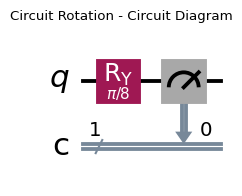


🔹 INITIAL STATE:


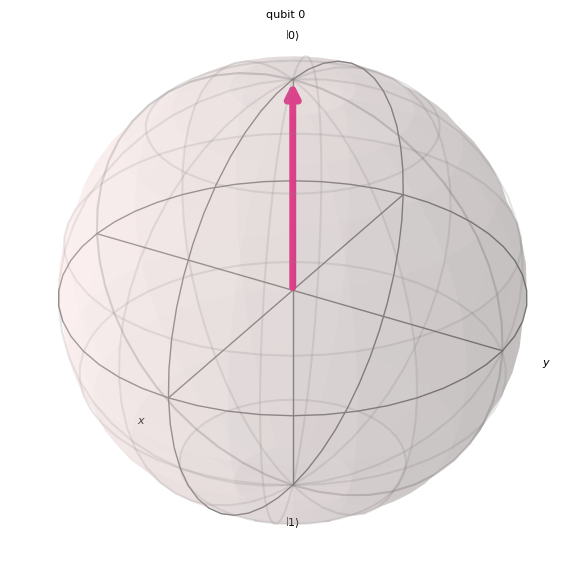


🔹 AFTER CIRCUIT ROTATION:


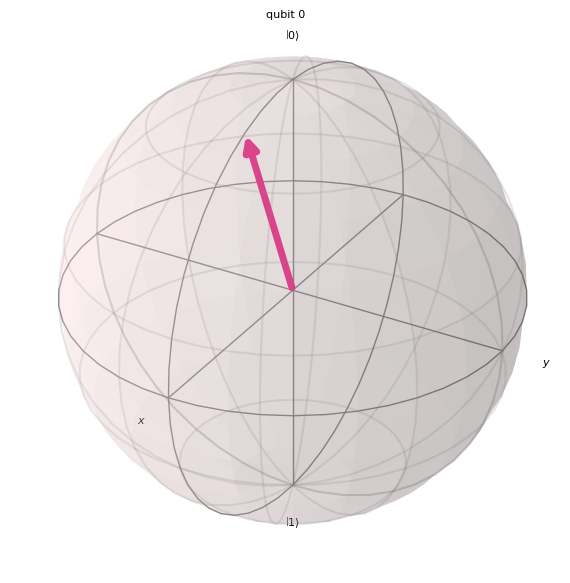

In [3]:
def gv_gate_circuit():
    qc = QuantumCircuit(1, 1)
    qc.ry(np.pi/8, 0)
    qc.measure(0, 0)
    return qc

create_and_visualize_gate("Circuit Rotation", gv_gate_circuit)